In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate, Flatten
import warnings
import shap
import nltk

In [2]:
warnings.filterwarnings("ignore")
np.random.seed(42)

In [3]:
file_path = 'reviews-with-sentiments.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=['review_id'])

# 0. Data Exploration

In [4]:
# Calculate the percentage of missing values for each column
missing_values = data.isnull().sum() / len(data) * 100
missing_values_table = pd.DataFrame({'Column': data.columns, 'Percentage Missing': missing_values})
missing_values_table.head()

,Column,Percentage Missing
sentiment,sentiment,28.4375
text,text,0.0000


In [5]:
# Basic statistics for each column
statistics_table = data.describe(include='all').transpose()

print("Statistics:")
statistics_table.head()

Statistics:


,count,unique,top,freq
sentiment,1145,2,positive,597
text,1600,1596,"I'd been searching for a cool, non-chain hotel...",2


In [6]:
# Splitting data into training and testing
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Drop missing test data
test_data = test_data.dropna(subset=['sentiment'])

# Calculate the percentage of missing values for each column in train data
missing_train = train_data.isnull().sum() / len(data) * 100
missing_train_table = pd.DataFrame({'Column': data.columns, 'Percentage Missing': missing_values})
missing_train_table.head()

,Column,Percentage Missing
sentiment,sentiment,28.4375
text,text,0.0000


## Build a random forest model to impute the missing sentiment in Train data

In [7]:
# Filter out rows with missing sentiment
train_known = train_data[train_data['sentiment'].notnull()]

# Feature Engineering - TF-IDF with unigrams, bigrams, and trigrams
tfidf_vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 3))  # Unigrams, bigrams, trigrams
X = tfidf_vectorizer.fit_transform(train_known['text']).toarray()
y = train_known['sentiment']

# plit data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=30,)

# Perform hyperparameter tuning
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [10, 30],
    'min_samples_split': [2, 10],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

#Evaluate the model
y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89        80
    positive       0.88      0.90      0.89        83

    accuracy                           0.89       163
   macro avg       0.89      0.89      0.89       163
weighted avg       0.89      0.89      0.89       163



## Inpute the missing training data

In [8]:
# Identify the missing data in the training set
train_missing = train_data[train_data['sentiment'].isnull()]

# Transform the text in the missing data using the same TF-IDF vectorizer
X_missing = tfidf_vectorizer.transform(train_missing['text']).toarray()
predicted_sentiments = best_model.predict(X_missing)
train_data.loc[train_data['sentiment'].isnull(), 'sentiment'] = predicted_sentiments

Out of the 1,120 rows in the training dataset, 28.43% (approximately 318 rows) had missing sentiment values. Discarding these rows would have significantly reduced the size of the training dataset, potentially leading to a loss of valuable information and impairing the model's ability to generalize well on new data.

Given that the model achieved an accuracy of 88.96% on the validation set, we can estimate the error rate for the imputed values. The model's error rate is approximately 11.04% (100% - 89%), meaning that about 11 out of every 100 predictions made by the model could be incorrect.

$$Expected Number of Incorrect Imputations = 318 × 0.1104 ≈ 35$$

This means that out of the 318 imputed sentiment values, we can expect approximately 35 of them to be incorrect.

### Why drop missing for test data?
Dropping rows with missing sentiment values in the test set rather than imputing them, we ensure that the model evaluation remains unbiased, accurate, and reflective of the model's true performance on complete and unseen data. This approach maintains the integrity of the testing process, leading to more reliable conclusions about the model's effectiveness.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


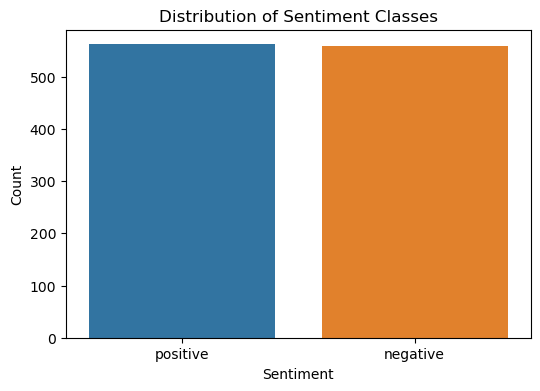

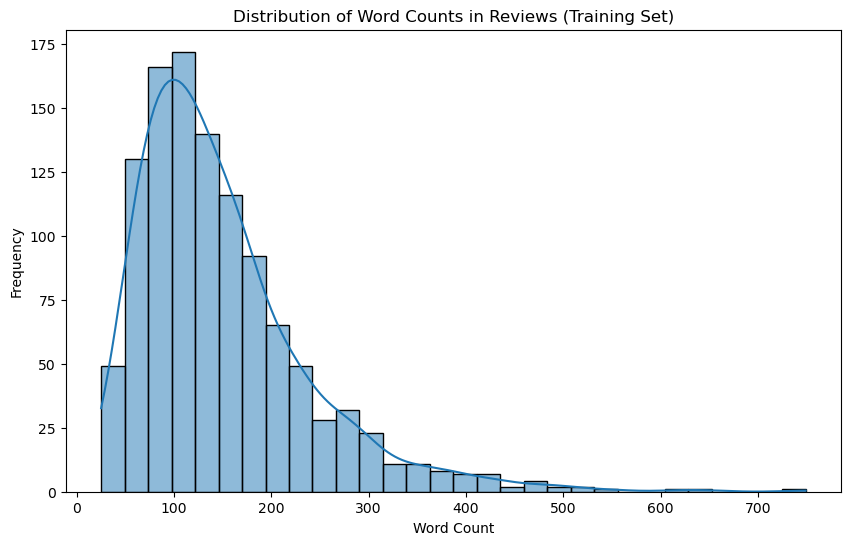

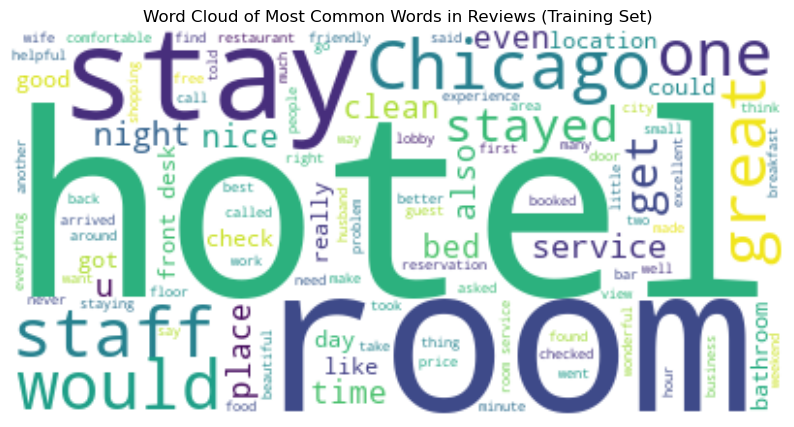

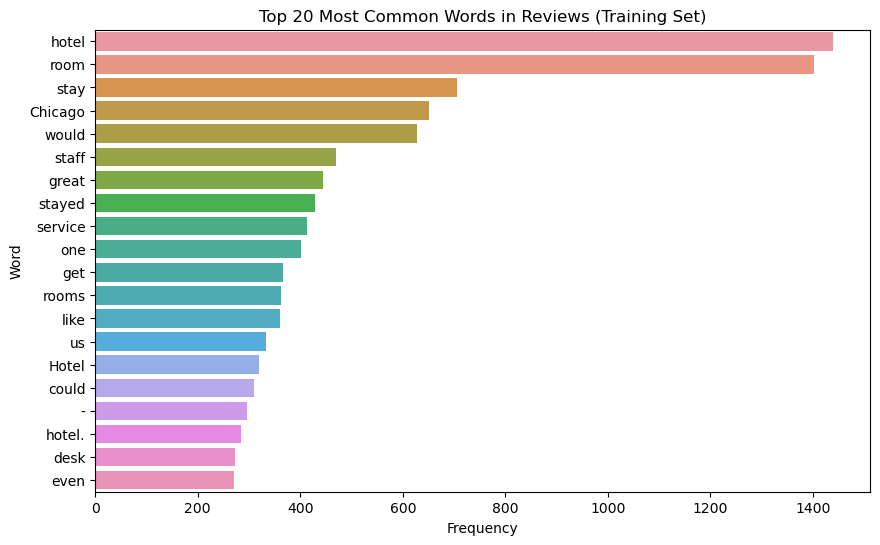

In [9]:
# Graphival representation of the train data
nltk.download('stopwords')

# Plot distribution of sentiment classes
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=train_data)
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Add a column for word count in the training data
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))

# Plot distribution of word counts
plt.figure(figsize=(10, 6))
sns.histplot(train_data['word_count'], bins=30, kde=True)
plt.title('Distribution of Word Counts in Reviews (Training Set)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Generate word cloud for the most common words in the training data
stop_words = set(stopwords.words('english'))
text = ' '.join(train_data['text'])
wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Reviews (Training Set)')
plt.show()

# Frequency of most common words
words = text.split()
words_filtered = [word for word in words if word.lower() not in stop_words]
word_freq = Counter(words_filtered)

# Display top 20 most common words
most_common_words = word_freq.most_common(20)
most_common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Plot the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=most_common_words_df)
plt.title('Top 20 Most Common Words in Reviews (Training Set)')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()



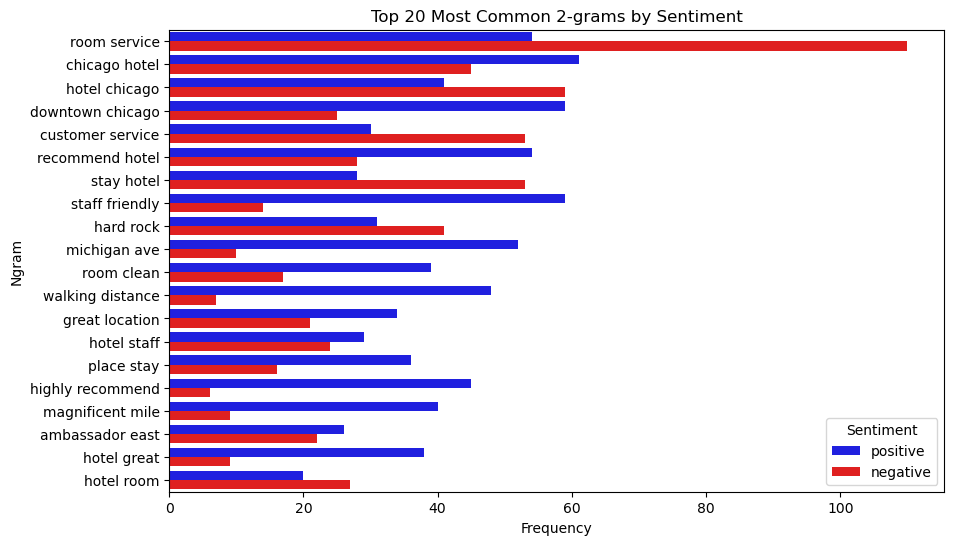

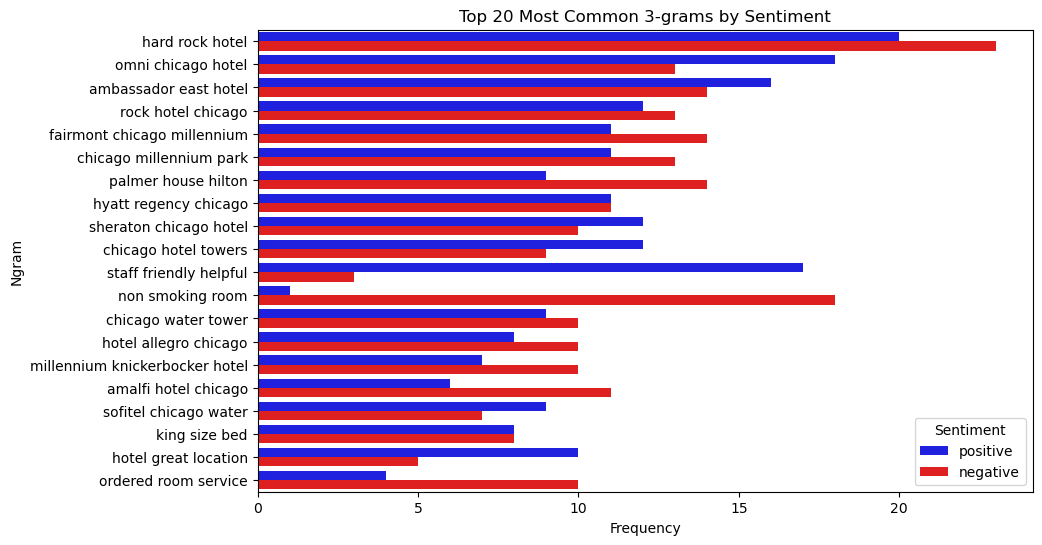

In [10]:
# Function to plot the most common n-grams (bigrams or trigrams)

def plot_ngrams_by_sentiment(data, sentiment_col='sentiment', text_col='text', ngram_range=(2, 2), top_n=20):
    """
    Plots the top n n-grams by sentiment from a text dataset.

    Parameters:
    -----------
    data : pandas.DataFrame
        A DataFrame containing the text data and sentiment labels.
    sentiment_col : str, optional, default='sentiment'
        The name of the column in the DataFrame that contains sentiment labels (e.g., 'positive', 'negative').
    text_col : str, optional, default='text'
        The name of the column in the DataFrame that contains the text data.
    ngram_range : tuple, optional, default=(2, 2)
        The range of n-grams to be extracted. (2, 2) extracts bigrams.
    top_n : int, optional, default=20
        The number of top n-grams to display in the plot.

    Returns:
    --------
    None
        This function displays a plot
    """
    
    # Initialize CountVectorizer to extract n-grams from the text data, ignoring English stop words.
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    
    # Fit the vectorizer on the text data and transform the text into a sparse matrix of n-gram counts.
    X = vectorizer.fit_transform(data[text_col])
    
    # Get the list of n-grams (features) from the vectorizer.
    ngrams = vectorizer.get_feature_names_out()
    
    # Sum the counts of each n-gram across all documents to get total frequencies.
    ngram_counts = X.toarray().sum(axis=0)
    
    # Create a DataFrame containing n-grams and their total frequencies.
    ngram_freq_df = pd.DataFrame({'Ngram': ngrams, 'Total_Frequency': ngram_counts})
    
    # Calculate the frequency of each n-gram in positive sentiment texts.
    ngram_freq_df['Positive_Freq'] = X[data[sentiment_col] == 'positive'].sum(axis=0).A1
    
    # Calculate the frequency of each n-gram in negative sentiment texts.
    ngram_freq_df['Negative_Freq'] = X[data[sentiment_col] == 'negative'].sum(axis=0).A1
    
    # Sort the DataFrame by total frequency and keep only the top n n-grams.
    ngram_freq_df = ngram_freq_df.sort_values(by='Total_Frequency', ascending=False).head(top_n)
    
    # Reshape the DataFrame for plotting: one row per n-gram per sentiment.
    ngram_freq_melted = ngram_freq_df.melt(id_vars='Ngram', value_vars=['Positive_Freq', 'Negative_Freq'], 
                                           var_name='Sentiment', value_name='Sentiment_Frequency')
    
    # Convert the sentiment column to display 'positive' or 'negative' for easier interpretation.
    ngram_freq_melted['Sentiment'] = ngram_freq_melted['Sentiment'].apply(lambda x: 'positive' if 'Positive' in x else 'negative')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Sentiment_Frequency', y='Ngram', hue='Sentiment', data=ngram_freq_melted, palette={'positive': 'blue', 'negative': 'red'})
    
    plt.title(f'Top {top_n} Most Common {ngram_range[0]}-grams by Sentiment')
    plt.xlabel('Frequency')
    plt.ylabel('Ngram')
    
    plt.legend(title='Sentiment')
    
    plt.show()


plot_ngrams_by_sentiment(train_data, ngram_range=(2, 2), top_n=20)
plot_ngrams_by_sentiment(train_data, ngram_range=(3, 3), top_n=20)


# Summary of Findings and Methodological Rationale

## Data Preparation and Initial Exploration

1. The dataset initially contained three columns: review_id, sentiment, and text. We dropped the review_id column as it was not necessary for analysis.
2. We identified that the sentiment column had missing values in 455 out of 1,600 rows.
3. We slipt the datasets into testing and training data. Whiles missing sentiment rows in the test data were drop , we performed imputation for the the training data using random forest.

## Focused Analysis on the Training Set
1. Sentiment Distribution: A balanced distribution between 'positive' and 'negative' sentiments was observed, there is no need trying to balance the the sentiments
2. Word Count Analysis: The reviews typically contained between 100 and 200 words, with an average word count of about 148 words.
3. Frequent Word Analysis: A word cloud and bar plot of the top 20 most common words revealed key themes and terms in the reviews, excluding common stopwords.
3. N-grams Analysis with Sentiment Distinction: The analysis of the top 20 most common 2-grams and 3-grams in customer reviews, categorized by sentiment, provides valuable insights into the key phrases that influence positive and negative perceptions. 

In the 2-gram analysis, phrases such as "room service" and "Chicago hotel" are frequently mentioned in both positive and negative contexts, with "room service" notably associated with more negative sentiment. This suggests that while room service is a significant aspect of customer experience, it may often lead to dissatisfaction, impacting overall sentiment negatively. On the other hand, phrases like "customer service" and "recommend hotel" are more prevalent in positive reviews, indicating that excellent customer service and the likelihood of recommending the hotel are strong drivers of positive sentiment.

In the 3-gram analysis, phrases such as "hard rock hotel" appear prominently in both sentiment categories, though with a stronger association with positive reviews, implying generally favorable experiences with this hotel, with some negative feedback. Similarly, "Omni Chicago hotel" and "ambassador east hotel" are frequently mentioned with a positive sentiment, reflecting customer satisfaction with these locations. The phrase "staff friendly helpful" is particularly associated with positive sentiment, underscoring the importance of courteous and helpful staff in shaping a positive customer experience. These findings highlight the critical areas that hotel management can focus on, such as improving room service and maintaining high standards of customer service, to enhance overall customer satisfaction and encourage positive reviews.

## Rationale for Analyzing the Training Set Only
1. Avoiding Data Leakage: All analysis was conducted exclusively on the training data to prevent data leakage. Data leakage occurs when information from the test set influences the training process, leading to overly optimistic performance estimates and a model that may not generalize well to unseen data.
2. Ensuring Valid Evaluation: By keeping the test data separate and untouched during analysis, we preserved its integrity for evaluating the model’s performance. This approach ensures that the model’s predictions on the test set reflect its true ability to generalize to new, unseen data.

# 1. Text Preprocessing:


In [11]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Preprocesses the input text by converting it to lowercase, removing special characters, 
    tokenizing, removing stopwords, and applying lemmatization.

    Parameters:
    -----------
    text : str
        The input string containing the text to be processed.

    Returns:
    --------
    str
        The processed text after applying all preprocessing steps.
    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text into individual tokens
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Apply lemmatization to each token
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join the tokens back into a single string to form the processed text
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply preprocessing to the training data
train_data['processed_text'] = train_data['text'].apply(preprocess_text)

In [12]:
train_data_processed = train_data[['sentiment', 'processed_text']]

1. Remove Special Characters, Numbers, and Punctuation: Special characters, numbers, and punctuation often don't contribute meaningful information in sentiment analysis. By removing them, we clean the text and focus on the actual words that carry sentiment, reducing noise and irrelevant data.
2. Tokenize the Text: Tokenization breaks down the text into individual words (tokens), which is crucial for further processing steps like removing stopwords and lemmatization. It allows us to handle each word separately, making it easier to analyze the text.
3. Remove Stopwords: Stopwords are common words (e.g., "and", "the") that don't carry much meaning and can dilute the impact of meaningful words in sentiment analysis. Removing them helps to concentrate on the words that are more likely to influence the sentiment of the text.
4. Apply Lemmatization: Lemmatization reduces words to their base or dictionary form, ensuring that different forms of a word (e.g., "running", "ran") are treated as the same word ("run"). This helps in maintaining consistency and preserving the meaning of the text, which is crucial for accurate sentiment analysis.

# 2. Feature Engineering:

In [13]:
# Load pre-trained GloVe embeddings
glove_embeddings = {}
with open("glove.6B.50d.txt", "r", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove_embeddings[word] = vector

# Function to get the average GloVe embedding for a sentence
def get_avg_glove(sentence):
    """
    Computes the average GloVe embedding for a given sentence.

    Parameters:
    -----------
    sentence : str
        The input sentence for which the average GloVe embedding is to be calculated.

    Returns:
    --------
    numpy.ndarray
        The average GloVe embedding vector for the sentence.
    """
    tokens = word_tokenize(sentence)
    embedding = np.mean([glove_embeddings[word] for word in tokens if word in glove_embeddings], axis=0)
    return embedding

# Apply GloVe embeddings to the processed text in the training data
train_data_processed['glove_embeddings'] = train_data_processed['processed_text'].apply(get_avg_glove)

# Handling any NaN values that might result from missing words
train_data_processed['glove_embeddings'] = train_data_processed['glove_embeddings'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(100))

# Convert the list of embeddings into a NumPy array for further processing
glove_embeddings_array = np.stack(train_data_processed['glove_embeddings'].values)


GloVe (Global Vectors for Word Representation) offers a balanced approach that suits both the need for quality embeddings and the practical considerations of computational efficiency and time constraints:
1. Less Computationally Expensive: GloVe embeddings are pre-trained on large corpora and are available as static word vectors. Unlike ELMo and BERT, GloVe does not require extensive computational resources or complex model architectures to generate embeddings. This makes GloVe significantly faster and less demanding on hardware.
2. Quicker Turnaround: Using GloVe, we can generate embeddings for our dataset in a fraction of the time required by ELMo or BERT. This is especially beneficial in production environments where quick responses and scalability are crucial.
3. Sufficient Performance: While ELMo and BERT offer state-of-the-art performance, GloVe embeddings are often sufficient for many NLP tasks, including sentiment analysis. GloVe captures both local context and global word co-occurrences, making it a reliable choice for tasks where computational efficiency is a priority.

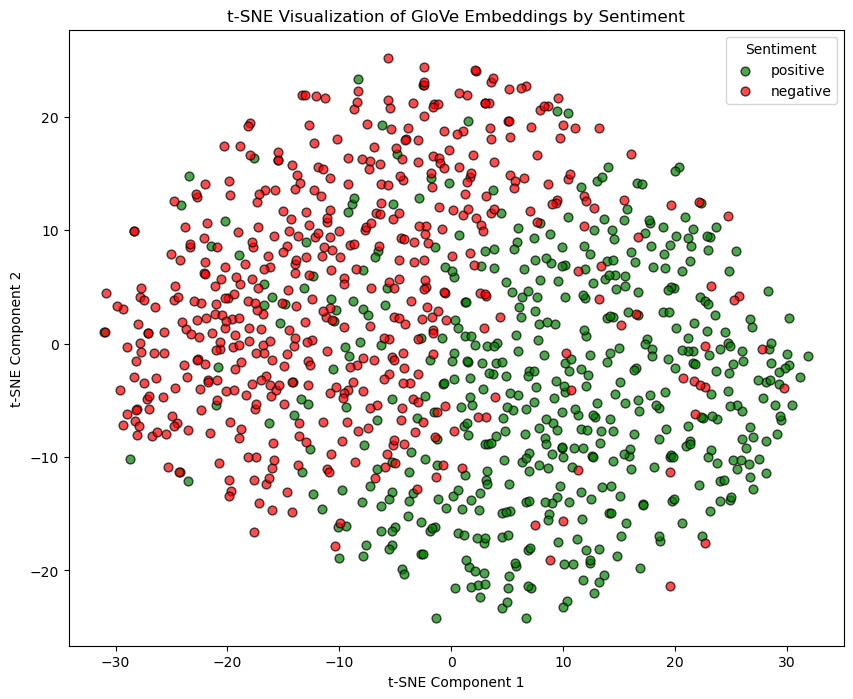

In [14]:
# GloVe Embeddings Plot

# Sample a subset of embeddings for visualization
sample_size = min(1000, len(glove_embeddings_array))
sample_indices = np.random.choice(len(glove_embeddings_array), sample_size, replace=False)
sample_embeddings = glove_embeddings_array[sample_indices]
sample_sentiments = train_data_processed['sentiment'].iloc[sample_indices]

# Map sentiments to colors
color_map = {'positive': 'green', 'negative': 'red'}
colors = sample_sentiments.map(color_map)

# Applying t-SNE to reduce embeddings to 2D space
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(sample_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
for sentiment in color_map:
    idx = sample_sentiments == sentiment
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=color_map[sentiment], label=sentiment, edgecolor='k', s=40, alpha=0.7)

plt.title("t-SNE Visualization of GloVe Embeddings by Sentiment")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Sentiment')
plt.show()


The plot shows that positive and negative sentiments are somewhat mixed together. There is no clear separation between the clusters of positive and negative sentiment points. This suggests that the GloVe embeddings alone might not be perfectly separating the sentiments in the dataset dataset.

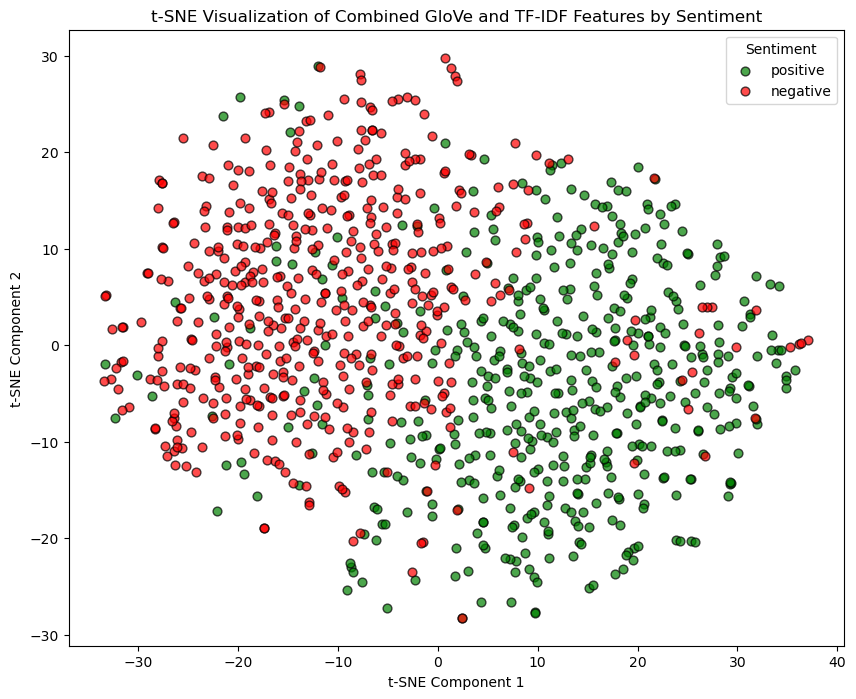

In [15]:
# Combined GloVe and TF-IDF Features

# Compute TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
tfidf_features = tfidf_vectorizer.fit_transform(train_data_processed['processed_text']).toarray()

# Combine GloVe embeddings with TF-IDF features
#Ensure GloVe embeddings are numpy arrays and handle any missing embeddings
glove_embeddings_array = np.stack(train_data_processed['glove_embeddings'].values)
combined_features = np.hstack([glove_embeddings_array, tfidf_features])

# Sample a subset of combined features for visualization
sample_size = min(1000, len(combined_features))
sample_indices = np.random.choice(len(combined_features), sample_size, replace=False)
sample_features = combined_features[sample_indices]
sample_sentiments = train_data_processed['sentiment'].iloc[sample_indices]

# Apply t-SNE to reduce combined features to 2D space
tsne = TSNE(n_components=2, random_state=42)
combined_embeddings_2d = tsne.fit_transform(sample_features)

# Visualize the combined embeddings with a legend
color_map = {'positive': 'green', 'negative': 'red'}
colors = sample_sentiments.map(color_map)

plt.figure(figsize=(10, 8))
for sentiment in color_map:
    idx = sample_sentiments == sentiment
    plt.scatter(combined_embeddings_2d[idx, 0], combined_embeddings_2d[idx, 1], c=color_map[sentiment], label=sentiment, edgecolor='k', s=40, alpha=0.7)

plt.title("t-SNE Visualization of Combined GloVe and TF-IDF Features by Sentiment")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Sentiment')
plt.show()


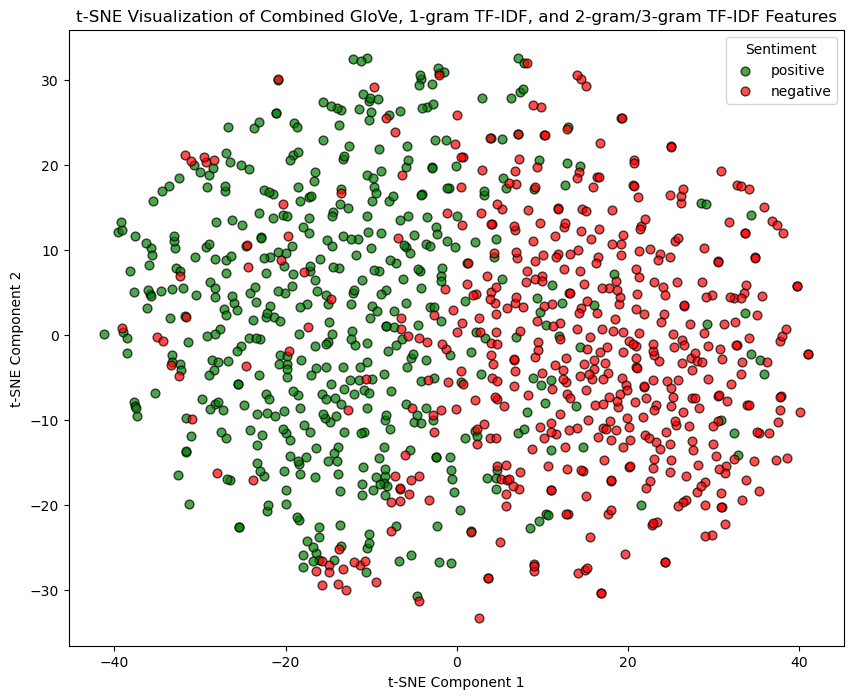

In [16]:
# Combined GloVe, 1-gram TF-IDF, and 2-gram/3-gram TF-IDF Features

# Compute 1-gram (unigram) TF-IDF features
tfidf_vectorizer_unigram = TfidfVectorizer(max_features=1000)
tfidf_features_unigram = tfidf_vectorizer_unigram.fit_transform(train_data_processed['processed_text']).toarray()

# Compute 2-gram or 3-gram TF-IDF features
tfidf_vectorizer_ngram = TfidfVectorizer(max_features=1000, ngram_range=(2, 3))
tfidf_features_ngram = tfidf_vectorizer_ngram.fit_transform(train_data_processed['processed_text']).toarray()

# Combine GloVe embeddings with 1-gram and n-gram (2-gram or 3-gram) TF-IDF features
glove_embeddings_array = np.stack(train_data_processed['glove_embeddings'].values)
combined_features = np.hstack([glove_embeddings_array, tfidf_features_unigram, tfidf_features_ngram])

# Sample a subset of combined features for visualization
sample_size = min(1000, len(combined_features))
sample_indices = np.random.choice(len(combined_features), sample_size, replace=False)
sample_features = combined_features[sample_indices]
sample_sentiments = train_data_processed['sentiment'].iloc[sample_indices]

# Apply t-SNE to reduce combined features to 2D space
tsne = TSNE(n_components=2, random_state=42)
combined_embeddings_2d = tsne.fit_transform(sample_features)

# Visualize the combined embeddings with a legend
color_map = {'positive': 'green', 'negative': 'red'}
colors = sample_sentiments.map(color_map)

plt.figure(figsize=(10, 8))
for sentiment in color_map:
    idx = sample_sentiments == sentiment
    plt.scatter(combined_embeddings_2d[idx, 0], combined_embeddings_2d[idx, 1], c=color_map[sentiment], label=sentiment, edgecolor='k', s=40, alpha=0.7)

plt.title("t-SNE Visualization of Combined GloVe, 1-gram TF-IDF, and 2-gram/3-gram TF-IDF Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Sentiment')
plt.show()


1. Best Separation: Combining GloVe, Unigram TF-IDF, and Bigram/Trigram TF-IDF Features shows the best clustering, with more distinct separation between positive and negative sentiments.
2. Minimal Overlap: There's less overlap compared to the first and second plots, indicating that the inclusion of n-grams (bigrams/trigrams) helps capture more contextual sentiment information, leading to clearer sentiment boundaries.
3. Cluster Shape: The clusters are more compact, which is usually indicative of better feature representation for distinguishing sentiments.

##  Test Data Preparation

In [17]:
# Load GloVe embeddings
glove_file_path = 'glove.6B.50d.txt'
glove_embeddings_dict = {}

with open(glove_file_path, 'r', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings_dict[word] = vector

def preprocess_and_transform_test_data(test_data, tfidf_vectorizer_unigram, tfidf_vectorizer_ngram, glove_embeddings_dict):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # Text preprocessing function
    def preprocess_text(text):
        
        """
        Preprocesses the text data and transforms it into a combined feature set including TF-IDF and GloVe embeddings.

        Parameters:
        -----------
        test_data : pandas.DataFrame
            A DataFrame containing the test data with at least one column 'text' that contains the raw text data.
        tfidf_vectorizer_unigram : sklearn.feature_extraction.text.TfidfVectorizer
            The pre-fitted TF-IDF vectorizer for unigram features.
        tfidf_vectorizer_ngram : sklearn.feature_extraction.text.TfidfVectorizer
            The pre-fitted TF-IDF vectorizer for n-gram features.
        glove_embeddings_dict : dict
            A dictionary containing GloVe word embeddings, where keys are words and values are embedding vectors.

        Returns:
        --------
        numpy.ndarray
            A NumPy array containing the combined features: GloVe embeddings, unigram TF-IDF features, and n-gram TF-IDF features.
        """
        
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        processed_text = ' '.join(tokens)
        
        return processed_text
    
    # GloVe embedding generation function
    def get_glove_embedding(text, glove_embeddings_dict):
        words = text.split()
        embeddings = [glove_embeddings_dict[word] for word in words if word in glove_embeddings_dict]
        if embeddings:
            return np.mean(embeddings, axis=0)
        else:
            return np.zeros(100)
    
    # Preprocess the text in the test data
    test_data['processed_text'] = test_data['text'].apply(preprocess_text)
    
    # Transform using the previously fitted TF-IDF vectorizers
    tfidf_features_unigram = tfidf_vectorizer_unigram.transform(test_data['processed_text']).toarray()
    tfidf_features_ngram = tfidf_vectorizer_ngram.transform(test_data['processed_text']).toarray()
    
    # GloVe embeddings for the test data
    test_data['glove_embeddings'] = test_data['processed_text'].apply(lambda x: get_glove_embedding(x, glove_embeddings_dict))
    glove_embeddings_array = np.stack(test_data['glove_embeddings'].values)
    
    combined_features = np.hstack([glove_embeddings_array, tfidf_features_unigram, tfidf_features_ngram])
    
    return combined_features

# 3. Model Building:

In [18]:
# Model Training data
train_combined_features = combined_features
train_labels = train_data_processed['sentiment'] 

# Model Testing data
test_combined_features = preprocess_and_transform_test_data(test_data, tfidf_vectorizer_unigram, tfidf_vectorizer_ngram, glove_embeddings_dict)
test_labels = test_data['sentiment'] 

### 3a. Random Forest

In [19]:
# Define the parameter grid
rf_param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [30, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
rf_grid_search.fit(train_combined_features, train_labels)

print("Best parameters for Random Forest:")
print(rf_grid_search.best_params_)
print(f"Best cross-validation accuracy for Random Forest: {rf_grid_search.best_score_ * 100:.2f}%")


# Evaluate the Random Forest model on the test set
best_rf_model = rf_grid_search.best_estimator_
y_test_pred_rf = best_rf_model.predict(test_combined_features)
print("\nRandom Forest Model Performance on Test Set:")
print(classification_report(test_labels, y_test_pred_rf))
print(f"Test Accuracy (Random Forest): {accuracy_score(test_labels, y_test_pred_rf) * 100:.2f}%")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters for Random Forest:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation accuracy for Random Forest: 90.45%

Random Forest Model Performance on Test Set:
              precision    recall  f1-score   support

    negative       0.91      0.87      0.89       150
    positive       0.90      0.93      0.91       180

    accuracy                           0.90       330
   macro avg       0.90      0.90      0.90       330
weighted avg       0.90      0.90      0.90       330

Test Accuracy (Random Forest): 90.30%


### 3b. Support Vector Machine (SVM)

In [20]:
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_model = SVC(probability=True,random_state=42)
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
svm_grid_search.fit(train_combined_features, train_labels)

print("\nBest parameters for SVM:")
print(svm_grid_search.best_params_)
print(f"Best cross-validation accuracy for SVM: {svm_grid_search.best_score_ * 100:.2f}%")

# Evaluate the SVM model on the test set
best_svm_model = svm_grid_search.best_estimator_
y_test_pred_svm = best_svm_model.predict(test_combined_features)
print("\nSVM Model Performance on Test Set:")
print(classification_report(test_labels, y_test_pred_svm))
print(f"Test Accuracy (SVM): {accuracy_score(test_labels, y_test_pred_svm) * 100:.2f}%")

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters for SVM:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy for SVM: 91.07%

SVM Model Performance on Test Set:
              precision    recall  f1-score   support

    negative       0.89      0.93      0.91       150
    positive       0.94      0.90      0.92       180

    accuracy                           0.91       330
   macro avg       0.91      0.91      0.91       330
weighted avg       0.91      0.91      0.91       330

Test Accuracy (SVM): 91.21%


### 3c. Long Short-Term Memory (LSTM)

In [21]:
max_vocab_size = 20000  # Maximum number of words to keep, based on word frequency
max_sequence_length = 150  # Maximum length of the input sequences

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(train_data_processed['processed_text'])

X_train_seq = tokenizer.texts_to_sequences(train_data_processed['processed_text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['processed_text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

y_train = pd.get_dummies(train_data_processed['sentiment']).values
y_test = pd.get_dummies(test_data['sentiment']).values

# Compute n-gram TF-IDF features
tfidf_vectorizer_ngram = TfidfVectorizer(max_features=1000, ngram_range=(1, 3))  # Unigrams, bigrams, trigrams
X_train_tfidf_ngram = tfidf_vectorizer_ngram.fit_transform(train_data_processed['processed_text']).toarray()
X_test_tfidf_ngram = tfidf_vectorizer_ngram.transform(test_data['processed_text']).toarray()

# Load pre-trained GloVe embeddings
embedding_dim = 50  # Dimension of GloVe embeddings
glove_file_path = 'glove.6B.50d.txt'

embedding_index = {}
with open(glove_file_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create the embedding matrix
word_index = tokenizer.word_index
num_words = min(max_vocab_size, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= max_vocab_size:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the LSTM model with TF-IDF n-gram features
# LSTM Branch
sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
embedding_layer = Embedding(input_dim=num_words,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(64))(x)
x = Dropout(0.5)(x)

# TF-IDF Branch
tfidf_input = Input(shape=(X_train_tfidf_ngram.shape[1],))
y = Dense(128, activation='relu')(tfidf_input)
y = Dropout(0.5)(y)

# Combine LSTM and TF-IDF branches
combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(2, activation='softmax')(z)

# Compile the model
model = Model(inputs=[sequence_input, tfidf_input], outputs=z)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit([X_train_pad, X_train_tfidf_ngram], y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Step 6: Evaluate the model on the test set
y_test_pred_proba = model.predict([X_test_pad, X_test_tfidf_ngram])
y_test_pred = np.argmax(y_test_pred_proba, axis=1)
y_test_true = np.argmax(y_test, axis=1)

print("\nLSTM + TF-IDF Model Performance on Test Set:")
print(classification_report(y_test_true, y_test_pred))
print(f"Test Accuracy (LSTM + TF-IDF): {accuracy_score(y_test_true, y_test_pred) * 100:.2f}%")

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 331ms/step - accuracy: 0.5719 - loss: 0.6831 - val_accuracy: 0.6920 - val_loss: 0.6498
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.6871 - loss: 0.5902 - val_accuracy: 0.7723 - val_loss: 0.4669
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.8412 - loss: 0.3999 - val_accuracy: 0.8036 - val_loss: 0.4699
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.8567 - loss: 0.3859 - val_accuracy: 0.8571 - val_loss: 0.3555
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.9010 - loss: 0.2894 - val_accuracy: 0.8571 - val_loss: 0.3696
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9094 - loss: 0.2314 - val_accuracy: 0.8839 - val_loss: 0.3134
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9323 - loss: 0.1951 - val_accuracy: 0.8839 - val_loss: 0.2735
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9524 - loss: 0.1533 - val_accuracy: 0

 98%|===================| 648/660 [01:00<00:01]        

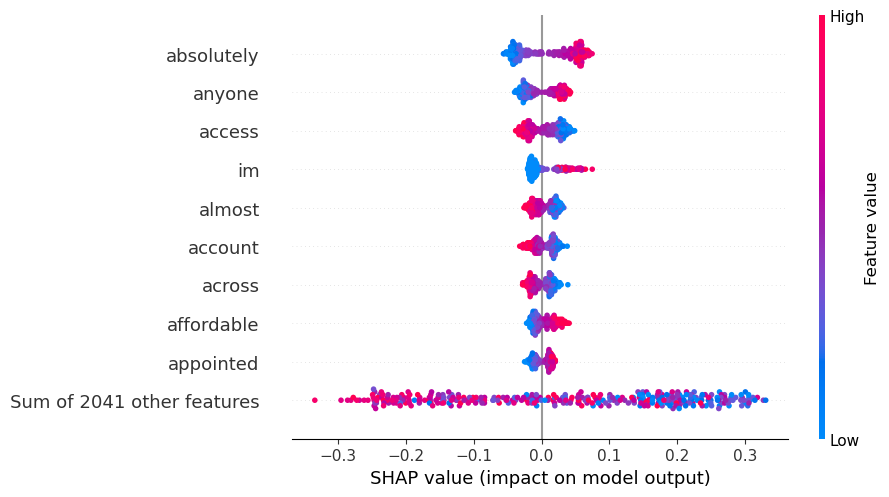

In [22]:
# Initialize the SHAP Explainer
explainer = shap.Explainer(best_rf_model, test_combined_features)

# Calculate SHAP values
shap_values = explainer(test_combined_features)


# If SHAP values are multidimensional, select the relevant dimension
# Select SHAP values for class 1
shap_values_class = shap_values[..., 1]

# Combine feature names (TF-IDF unigrams, TF-IDF n-grams, and GloVe embeddings)
combined_feature_names = np.concatenate([
    tfidf_vectorizer_unigram.get_feature_names_out(),
    tfidf_vectorizer_ngram.get_feature_names_out(),
    [f'glove_dim_{i}' for i in range(glove_embeddings_array.shape[1])]
])

# Add feature names to shap_values object
shap_values_class.feature_names = combined_feature_names
shap.plots.beeswarm(shap_values_class)

# 4. Model Interpretation:

### Model Performance

We evaluated three models Random Forest, Support Vector Machine (SVM), and LSTM + TF-IDF to determine which was most effective. Among these models, the LSTM + TF-IDF model outperform the other models across all key performance metrics, making it the best choice for this task. 
The LSTM + TF-IDF model achieved an impressive accuracy of  ≈94%, meaning that it correctly classified the sentiment in over 94% of the cases. This high accuracy indicates the model's reliability in general sentiment classification, making it highly effective for practical applications where accuracy is paramount.
When examining precision, the LSTM + TF-IDF model particularly excelled in identifying positive sentiment, with a precision score of 95%. This means that when the model predicted a positive sentiment, it was correct 95% of the time, significantly reducing the likelihood of false positives. This high precision is crucial in applications where the cost of false positives is high, such as in customer feedback analysis where positive reviews must be accurately identified.
In terms of recall, the LSTM + TF-IDF model also demonstrated its strength, particularly in detecting negative sentiments, achieving a recall rate of 94%. This metric highlights the model’s sensitivity, ensuring that most negative sentiments were correctly identified. High recall is particularly important in scenarios where failing to detect negative sentiment could lead to missed opportunities for improvement or unaddressed customer complaints. 
The model’s F1-score, which balances both precision and recall, was 94%, reflecting its consistent performance across different sentiment classes. The F1-score underscores the model's ability to not only make accurate predictions but to do so reliably across both positive and negative sentiments.


The LSTM + TF-IDF model emerged as the best-performing model, several factors contributed to the superior performance in this task:

1. Sequential Understanding: Unlike Random Forest and SVM, the LSTM model is designed to capture the sequential and temporal relationships between words in a sentence. This is crucial in sentiment analysis, where the order of words can significantly alter the meaning of a sentence.
2. Contextual Learning: LSTM's ability to maintain long-term dependencies allows it to understand context better, which is often lost in models like Random Forest and SVM that treat features independently. For example, the phrase "not good" would be more accurately interpreted by an LSTM model as negative sentiment compared to models that might focus on individual words without context.
3. Hybrid Approach with TF-IDF: Combining LSTM's strength in sequence modeling with TF-IDF's ability to capture important word features provided a balanced approach, leveraging both global word importance and local sequential dependencies.

### SHAP Summary Plot Interpretation
The SHAP summary plot provides insights into the most influential words that impact the sentiment predictions made by the Random Forest model. Understanding the SHAP values is important for validating the model's decision-making process and ensuring that it aligns with domain knowledge. For example, if the model heavily relies on certain words that do not logically contribute to sentiment, this might indicate a need for further retraining of the model. Here's a detailed interpretation based on the provided SHAP plot:

1. Feature Importance and Direction of Impact: The SHAP summary plot ranks features (words) based on their importance to the model’s output. The top features, such as "absolutely," "anyone," and "access," are shown to have the most significant impact on sentiment classification.
2. Positive SHAP Values (Right of the center line): Words with positive SHAP values (e.g., "absolutely," "anyone") push the model's prediction towards the positive sentiment class. The more these words appear in the text, the more likely the model is to classify the sentiment as positive.
2. Negative SHAP Values (Left of the center line): Conversely, words with negative SHAP values (e.g., "access," "im") push the prediction towards negative sentiment. These words decrease the probability of the model predicting a positive sentiment.


The SHAP analysis provided a valuable interpretation of the Random Forest model’s behavior. Although computational constraints prevented similar detailed analyses for the SVM and LSTM models, it is likely that similar patterns would emerge, particularly with respect to how key words influence sentiment predictions.

# 5. Conclusion and Recommendations:

We encountered several challenges that impacted our ability to fully optimize and interpret the models. One of the primary challenges was the significant computational cost associated with performing SHAP analysis, especially for more complex models like LSTM and SVM. These models, while powerful and capable of capturing intricate patterns in the data, required extensive computational resources for SHAP analysis, making it impractical to thoroughly assess their interpretability across large datasets. Another challenge was the desire to expand the grid search for more comprehensive hyperparameter tuning. However, due to limited computational resources, we were unable to explore a broader range of parameters, which may have constrained the optimization of our models. Additionally, integrating advanced embeddings like BERT was recognized as a potential avenue for improvement, but the complexity and resource demands of such an approach were beyond the scope of this project.

To address these challenges and improve the performance of our models, several recommendations are proposed. First, model optimization remains a key area of focus. While the LSTM + TF-IDF model already demonstrated strong performance, further hyperparameter tuning and optimization could lead to even better results. Exploring techniques like Bayesian Optimization or a more extensive Grid Search could help fine-tune the model more effectively. Second, incorporating more advanced embeddings such as BERT or GPT-based models could enhance the model’s ability to understand complex linguistic nuances, leading to improved accuracy in sentiment analysis. Finally, the implementation of a real-time sentiment analysis system could be highly beneficial for applications requiring immediate feedback. This would involve optimizing the model for both accuracy and speed, ensuring it can be deployed efficiently in dynamic, scalable environments.